In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from PIL import Image
import cv2

# ========== PIPELINE CONFIGURATION ==========
Pilihan:

1️⃣ Folder mode
DATA_DIR = "data/train"

2️⃣ CSV mode
CSV_PATH = "data.csv"  # kolom: ['image_path', 'label']

In [51]:
def load_dataset(image_paths="image_paths", labels="labels", mode="folder", data_dir=None, csv_path=None):
    if mode == "folder":
        image_paths = []
        labels = []
        for class_name in os.listdir(data_dir):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                files = glob.glob(os.path.join(class_dir, "*"))
                for f in files:
                    if f.split(".")[-1].lower() in IMG_EXT:
                        image_paths.append(f)
                        labels.append(class_name)
        df = pd.DataFrame({"image_path": image_paths, "label": labels})
    elif mode == "csv":
        df = pd.read_csv(csv_path)
        assert all(c in df.columns for c in [image_paths, labels]), "CSV must contain 'image_path' and 'label'"
    else:
        raise ValueError("mode must be 'folder' or 'csv'")

    df = df.sample(frac=1).reset_index(drop=True)
    print(f"✅ Loaded {len(df)} images across {df[labels].nunique()} classes.")
    return df

In [58]:
def show_samples(df, data_dir = None, n_per_class=3, image_paths="image_paths", labels="labels" ):
      classes = df[labels].unique()
      for cls in classes:
          subset = df[df[labels] == cls].sample(min(n_per_class, len(df[df[labels] == cls])))
          plt.figure(figsize=(n_per_class * 2, 2))
          for i, (_, row) in enumerate(subset.iterrows()):
              if data_dir is not None:
                  img = Image.open(os.path.join(data_dir, row[image_paths]))
              else:
                  img = Image.open(row[image_paths])
              plt.subplot(1, n_per_class, i + 1)
              plt.imshow(img)
              plt.axis('off')
              plt.title(cls)
          plt.tight_layout()
          plt.show()



In [79]:
def compute_image_stats(
    df,
    sample_size=200,
    image_col="image_path",
    label_col="labels",
    data_dir=None,
    per_class=False
):
    """
    Compute mean and std of RGB values for images.
    Optionally compute per-class stats as well.

    Args:
        df (pd.DataFrame): dataframe with image paths and labels.
        sample_size (int): number of samples to use for computing stats.
        image_col (str): column name for image paths.
        label_col (str): column name for labels.
        data_dir (str or None): optional base directory for image paths.
        per_class (bool): if True, also compute mean/std per class.

    Returns:
        mean_rgb (np.array): mean of RGB across sampled images.
        std_rgb (np.array): std of RGB across sampled images.
        per_class_stats (dict): {class_name: {"mean": ..., "std": ...}}
    """
    sample_df = df.sample(min(sample_size, len(df))).reset_index(drop=True)
    mean_rgb, std_rgb = [], []
    per_class_stats = {}

    # ---- main loop ----
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Computing RGB stats"):
        path = row[image_col]
        label = row[label_col] if label_col in row else "unknown"
        if data_dir is not None:
            path = os.path.join(data_dir, path)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

        mean = img.mean(axis=(0, 1))
        std = img.std(axis=(0, 1))

        mean_rgb.append(mean)
        std_rgb.append(std)

        # Per-class tracking
        if per_class:
            if label not in per_class_stats:
                per_class_stats[label] = {"mean": [], "std": []}
            per_class_stats[label]["mean"].append(mean)
            per_class_stats[label]["std"].append(std)

    # ---- overall stats ----
    mean_rgb = np.mean(mean_rgb, axis=0)
    std_rgb = np.mean(std_rgb, axis=0)

    # ---- per-class aggregation ----
    if per_class:
        for cls in per_class_stats:
            per_class_stats[cls]["mean"] = np.mean(per_class_stats[cls]["mean"], axis=0)
            per_class_stats[cls]["std"] = np.mean(per_class_stats[cls]["std"], axis=0)

    if per_class:
        return mean_rgb, std_rgb, per_class_stats
    else:
        return mean_rgb, std_rgb


# Kaggle Setup

In [4]:
! pip install -q kaggle

In [6]:
 from google.colab import files

 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fadqash","key":"78aea5159045ef05043191754847a2d3"}'}

In [8]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

# Card Dataset

In [14]:
! kaggle datasets download  'gpiosenka/cards-image-datasetclassification'

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
 73% 280M/385M [00:06<00:02, 39.7MB/s]
100% 385M/385M [00:06<00:00, 63.1MB/s]


In [16]:
! mkdir card-dataset
! unzip cards-image-datasetclassification -d card-dataset

Streaming output truncated to the last 5000 lines.
  inflating: card-dataset/train/jack of spades/059.jpg  
  inflating: card-dataset/train/jack of spades/060.jpg  
  inflating: card-dataset/train/jack of spades/061.jpg  
  inflating: card-dataset/train/jack of spades/062.jpg  
  inflating: card-dataset/train/jack of spades/063.jpg  
  inflating: card-dataset/train/jack of spades/064.jpg  
  inflating: card-dataset/train/jack of spades/065.jpg  
  inflating: card-dataset/train/jack of spades/066.jpg  
  inflating: card-dataset/train/jack of spades/067.jpg  
  inflating: card-dataset/train/jack of spades/068.jpg  
  inflating: card-dataset/train/jack of spades/069.jpg  
  inflating: card-dataset/train/jack of spades/070.jpg  
  inflating: card-dataset/train/jack of spades/071.jpg  
  inflating: card-dataset/train/jack of spades/072.jpg  
  inflating: card-dataset/train/jack of spades/073.jpg  
  inflating: card-dataset/train/jack of spades/074.jpg  
  inflating: card-dataset/train/jack 

In [64]:
MODE = "csv"  # "folder" atau "csv"
DATA_DIR = "/content/card-dataset"
CSV_PATH = "/content/card-dataset/cards.csv" # kalau pakai CSV

IMAGE_ROW = "filepaths"

IMG_EXT = ['jpg', 'jpeg', 'png', 'bmp', 'tiff']


In [65]:
df = load_dataset(mode=MODE, data_dir=DATA_DIR, csv_path=CSV_PATH, image_paths=IMAGE_ROW)

✅ Loaded 8155 images across 53 classes.


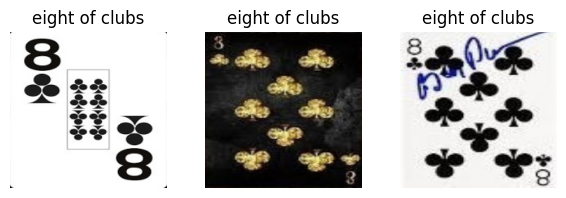

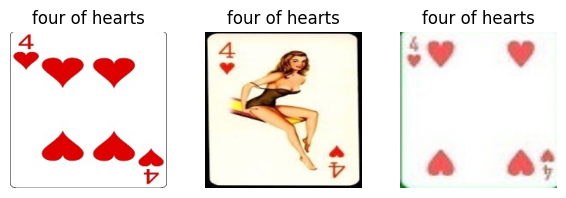

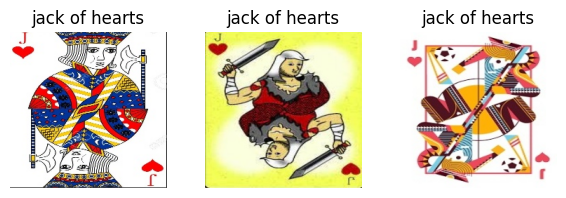

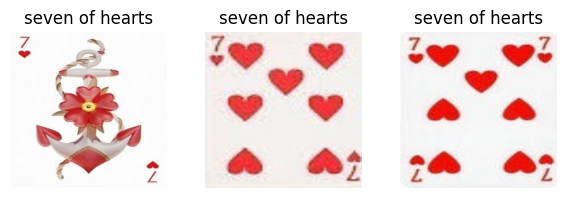

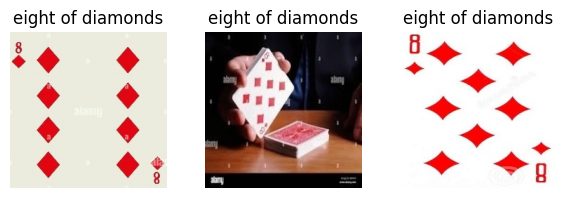

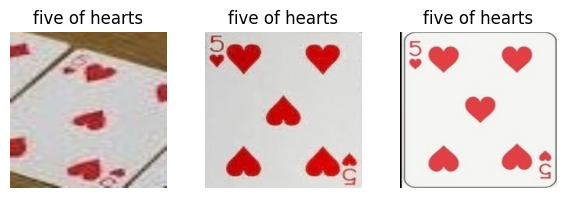

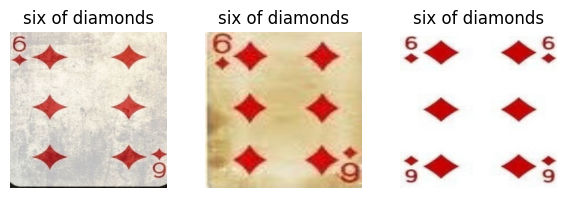

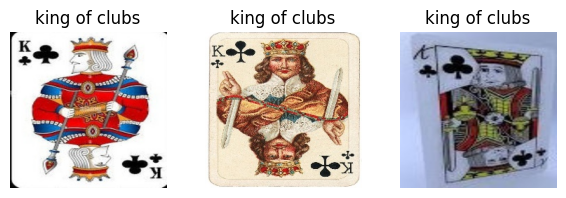

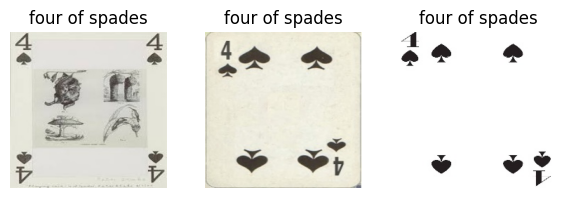

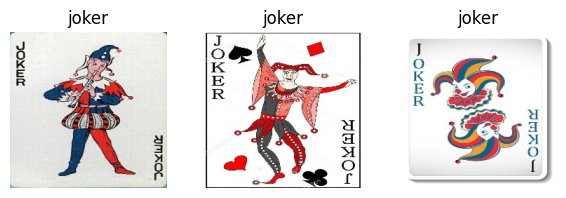

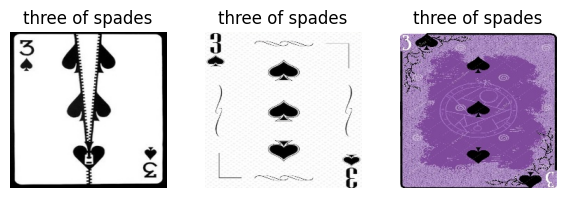

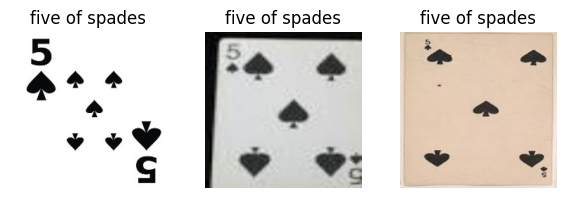

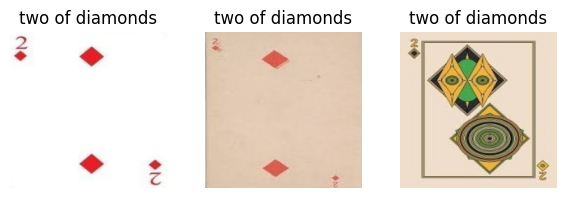

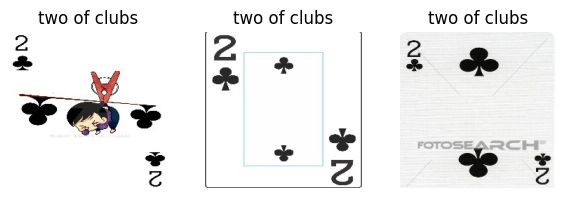

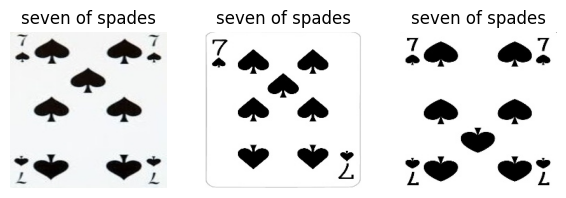

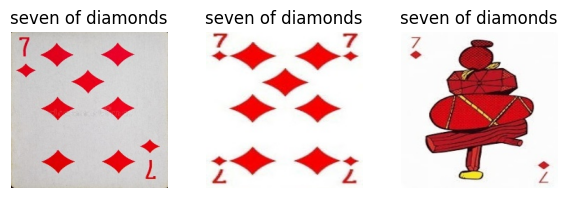

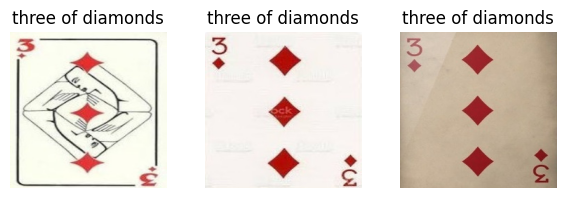

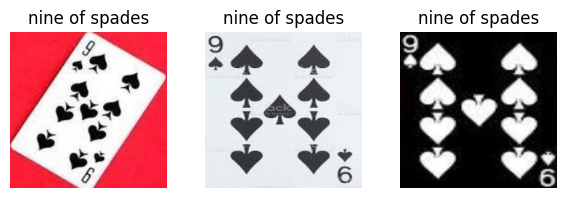

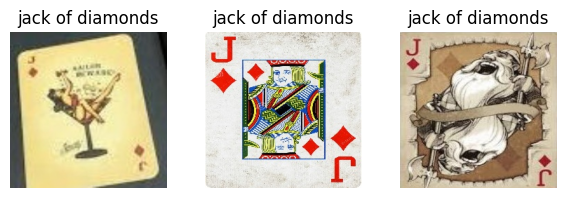

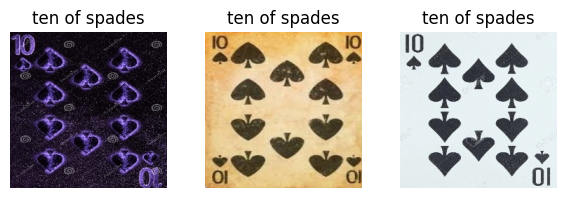

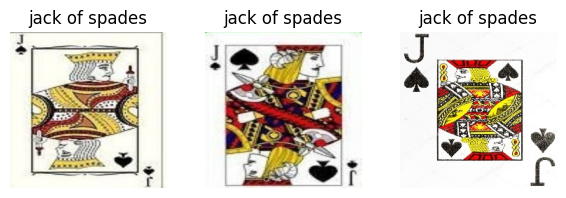

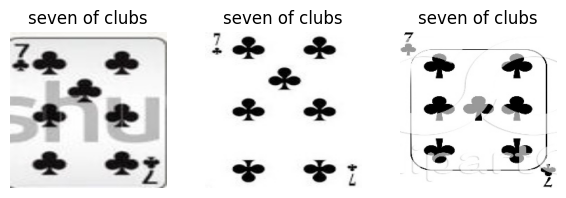

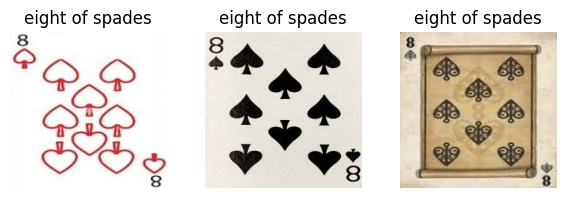

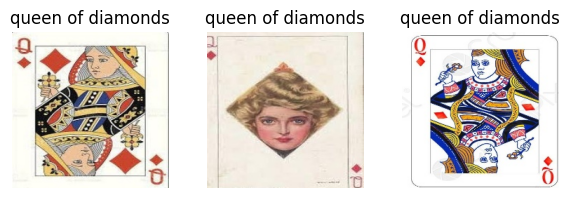

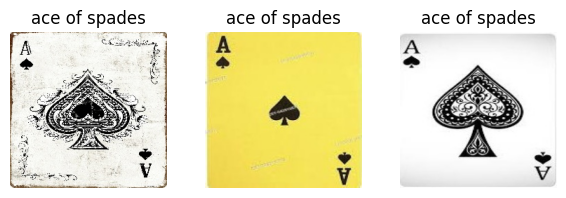

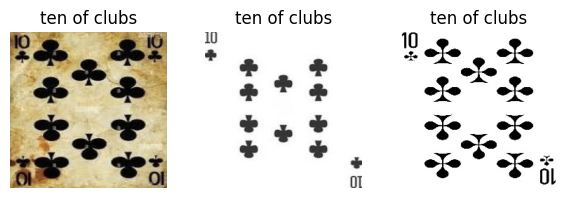

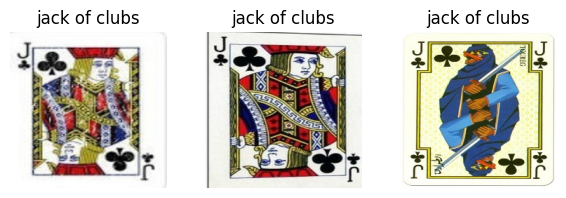

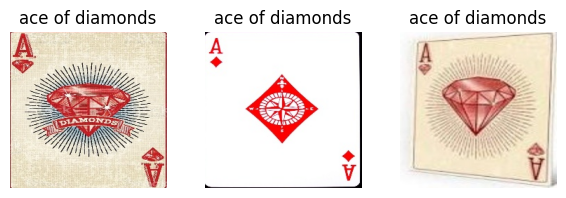

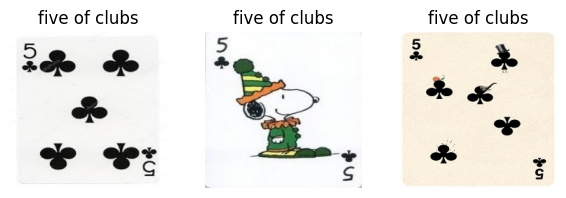

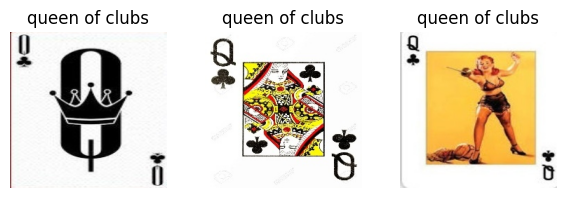

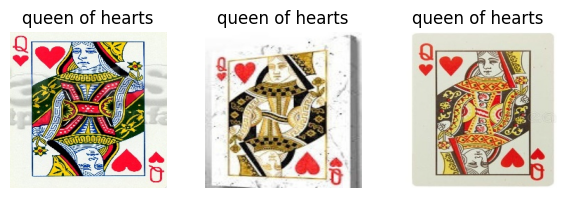

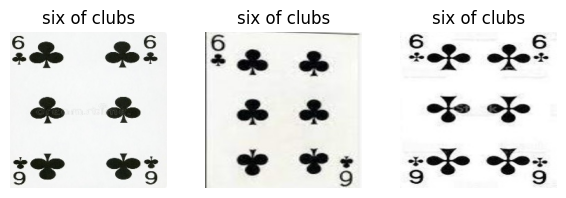

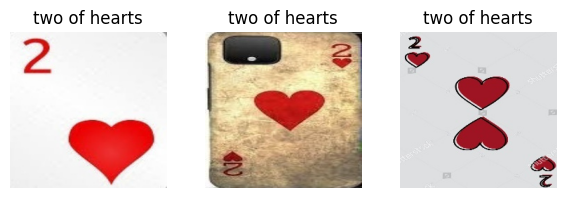

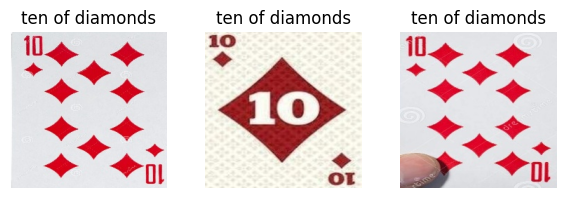

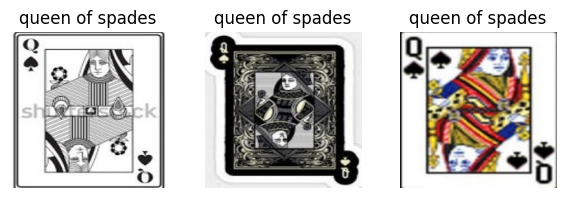

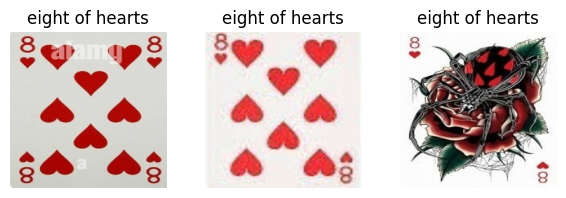

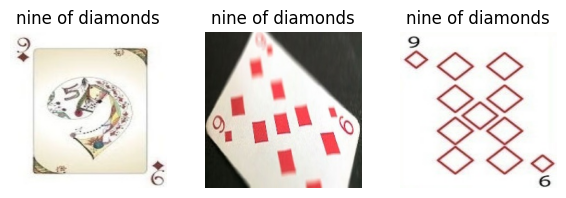

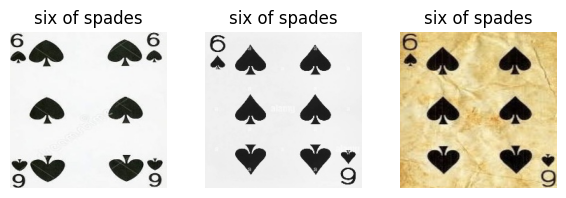

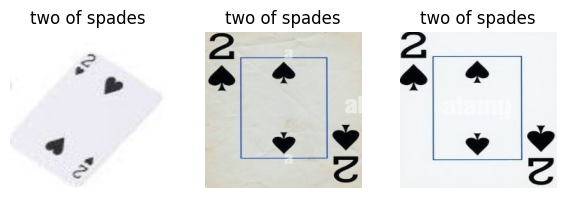

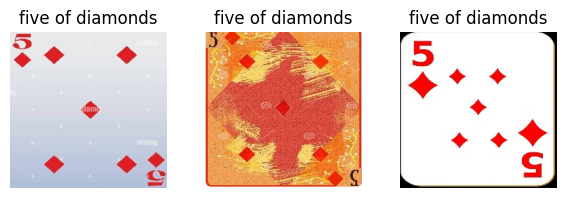

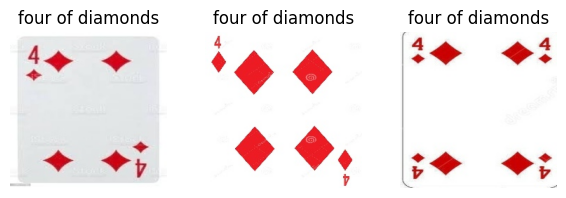

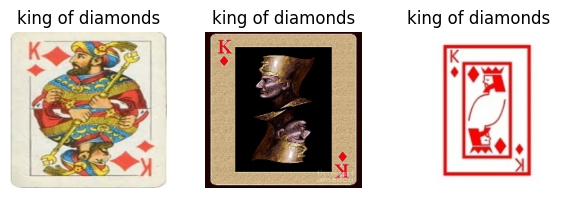

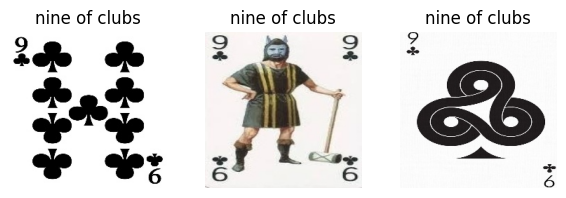

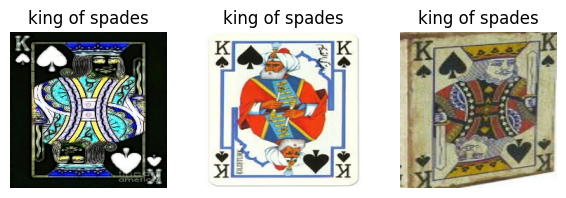

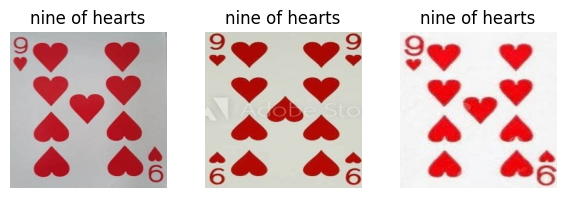

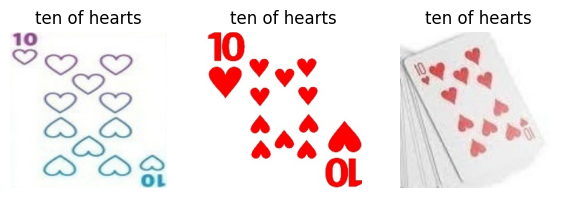

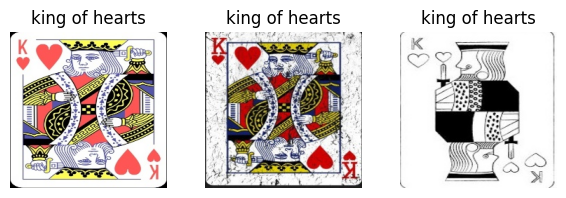

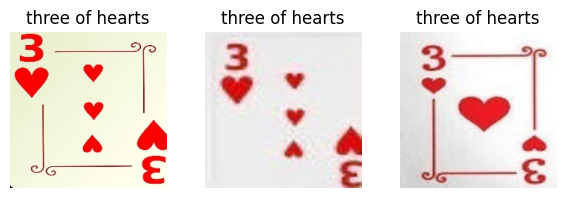

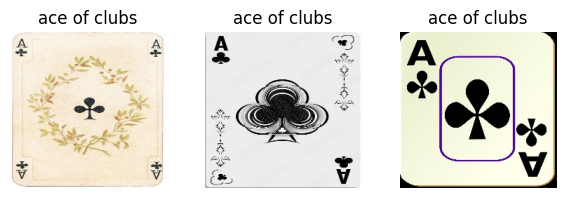

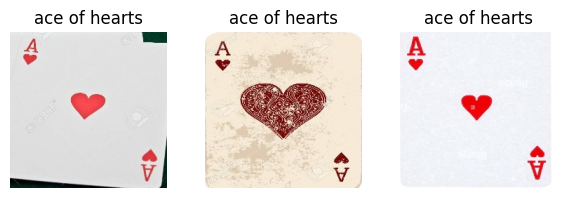

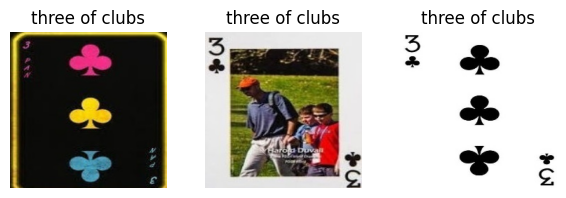

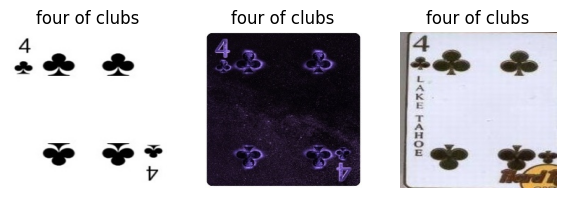

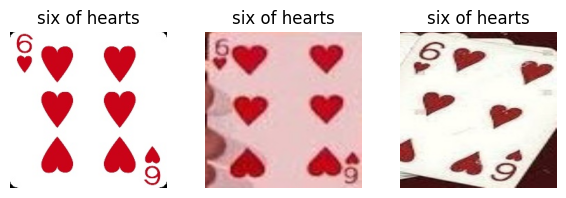

In [66]:
show_samples(df, image_paths=IMAGE_ROW, data_dir=DATA_DIR)

   class index                     filepaths          labels card type  \
0           45  train/three of clubs/064.jpg  three of clubs     three   
1           41      valid/ten of clubs/4.jpg    ten of clubs       ten   
2           20           train/joker/027.jpg           joker       xxx   
3           10  train/five of hearts/085.jpg  five of hearts      five   
4           16   train/jack of clubs/085.jpg   jack of clubs      jack   

  data set  
0    train  
1    valid  
2    train  
3    train  
4    train  

Class Distribution:
labels
ace of spades        191
jack of spades       182
ace of hearts        181
jack of clubs        181
jack of hearts       178
seven of spades      175
queen of diamonds    173
queen of spades      172
queen of clubs       171
jack of diamonds     170
eight of diamonds    169
five of spades       168
ten of spades        168
six of spades        168
four of clubs        167
two of spades        165
two of hearts        165
nine of spades       164

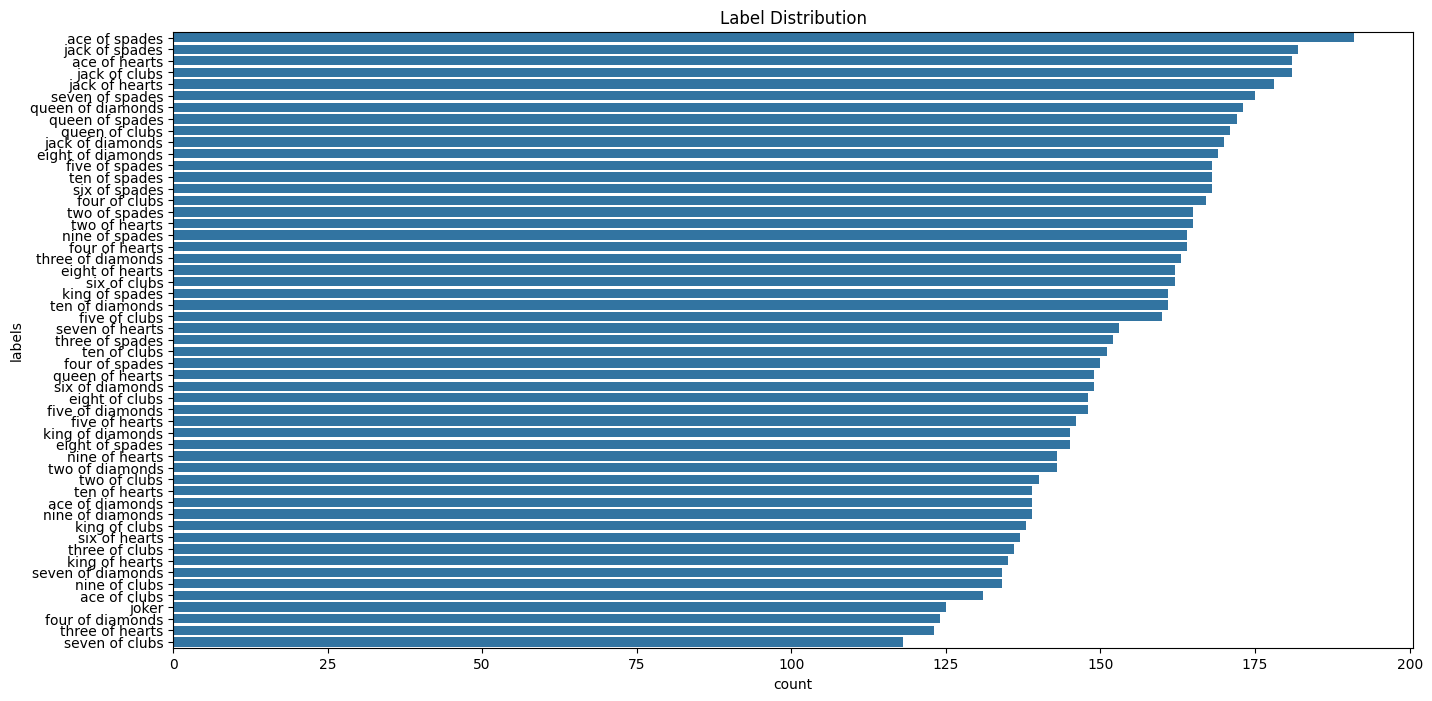

In [47]:
print(df.head())
print("\nClass Distribution:")
print(df['labels'].value_counts())

# Plot class distribution
plt.figure(figsize=(16,8))
sns.countplot(y=df['labels'], order=df['labels'].value_counts().index)
plt.title("Label Distribution")
plt.show()

Analyzing image sizes: 100%|██████████| 8155/8155 [00:01<00:00, 6336.77it/s] 


        width  height  aspect_ratio
count  8154.0  8154.0        8154.0
mean    224.0   224.0           1.0
std       0.0     0.0           0.0
min     224.0   224.0           1.0
25%     224.0   224.0           1.0
50%     224.0   224.0           1.0
75%     224.0   224.0           1.0
max     224.0   224.0           1.0


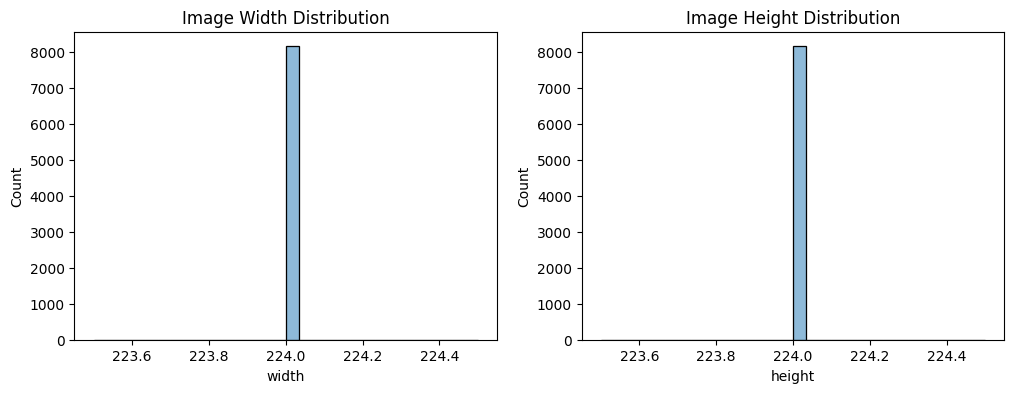

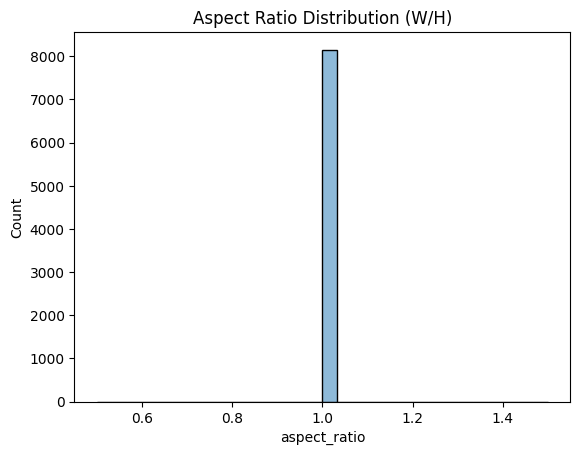

In [72]:
widths, heights, ratios = [], [], []
for path in tqdm(df[IMAGE_ROW], desc="Analyzing image sizes"):
    try:
        with Image.open(os.path.join(DATA_DIR, path)) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            ratios.append(w / h)
    except:
        widths.append(None)
        heights.append(None)
        ratios.append(None)

df['width'] = widths
df['height'] = heights
df['aspect_ratio'] = ratios

print(df[['width','height','aspect_ratio']].describe())

# Plot image size distribution
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['width'], ax=axes[0], kde=True, bins=30)
sns.histplot(df['height'], ax=axes[1], kde=True, bins=30)
axes[0].set_title("Image Width Distribution")
axes[1].set_title("Image Height Distribution")
plt.show()

sns.histplot(df['aspect_ratio'], kde=True, bins=30)
plt.title("Aspect Ratio Distribution (W/H)")
plt.show()

In [83]:
df[['width', "height"]].head()

width  height
0  224.0   224.0
1  224.0   224.0
2  224.0   224.0
3  224.0   224.0
4  224.0   224.0

In [80]:
mean_rgb, std_rgb, per_class_stats = compute_image_stats(df, image_col=IMAGE_ROW, data_dir= DATA_DIR,   per_class=True)
print("Global Mean RGB:", mean_rgb)
print("Global Std RGB:", std_rgb)
print("\nPer-Class Mean/Std:")
for cls, stats in per_class_stats.items():
    print(f"{cls}: Mean {stats['mean']}, Std {stats['std']}")

Computing RGB stats: 100%|██████████| 200/200 [00:00<00:00, 222.27it/s]

Global Mean RGB: [0.77765252 0.73474944 0.71334221]
Global Std RGB: [0.23626993 0.28346217 0.27960835]

Per-Class Mean/Std:
joker: Mean [0.79333989 0.77738796 0.76800824], Std [0.32379333 0.33834157 0.33348938]
nine of spades: Mean [0.82278062 0.82824593 0.82024458], Std [0.31025924 0.30552536 0.29507652]
queen of hearts: Mean [0.81524516 0.73957737 0.70591948], Std [0.28484888 0.34839912 0.34575929]
jack of hearts: Mean [0.62465444 0.53644622 0.4759787 ], Std [0.30012769 0.32553144 0.31821072]
ace of spades: Mean [0.7068712  0.65417169 0.55791852], Std [0.30792622 0.28940317 0.24649926]
ten of clubs: Mean [0.75630678 0.74939718 0.74588664], Std [0.34805252 0.34989799 0.34375738]
three of spades: Mean [0.83766178 0.81915686 0.78179303], Std [0.24551162 0.24356248 0.23822357]
four of diamonds: Mean [0.93762431 0.87591052 0.88560096], Std [0.07506779 0.24010751 0.24257665]
seven of diamonds: Mean [0.86897189 0.8135966  0.81737125], Std [0.16141492 0.26288488 0.24914884]
queen of clubs: M